## Simple illustrative systems

### Linear 2D ODE

$$ \frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix} $$

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import odeint
from scipy.io import loadmat

In [2]:
def f(x, t):
    return [
        -0.1 * x[0] + 2 * x[1],
        -2 * x[0] - 0.1 * x[1]        
    ]


dt = 0.01
t_train = np.arange(0, 25, dt)
x0_train = [2, 0]
x_train = odeint(f, x0_train, t_train)

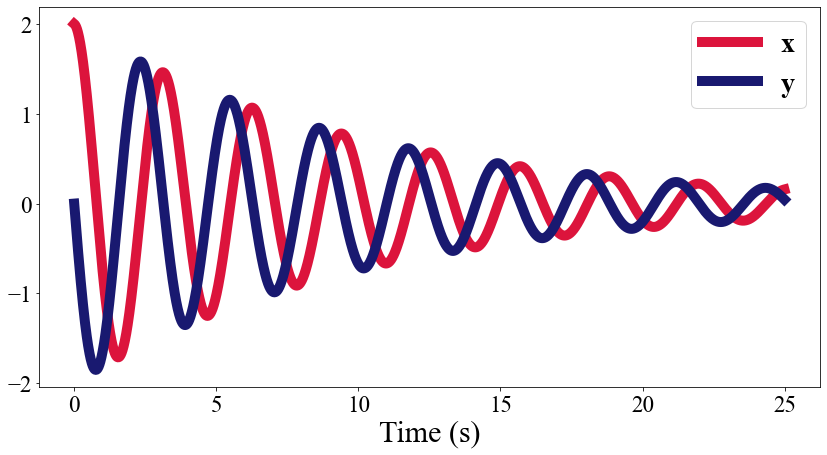

In [3]:
#size of pictures
figsize = 14,7
figure, ax = plt.subplots(figsize=figsize)
 
#Draw two lines on the same picture
plt.plot(t_train, x_train[:, 0],'crimson',label='x',linewidth=10.0)
plt.plot(t_train, x_train[:, 1], 'midnightblue',label='y',linewidth=10.0)
 
#set the legend and the fontsize 
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 23,
}
plt.legend(loc='upper right',prop={'family':'Times New Roman','weight':'bold','size':28})
 
#Set the size of the coordinate scale value and the font
plt.tick_params(labelsize=23)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
 
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 30,
}

font3 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 40,
}
plt.xlabel('Time (s)',font2)
#plt.title("Linear system",font3)
plt.savefig("./Linear.jpg",dpi=2000)  # save

No handles with labels found to put in legend.


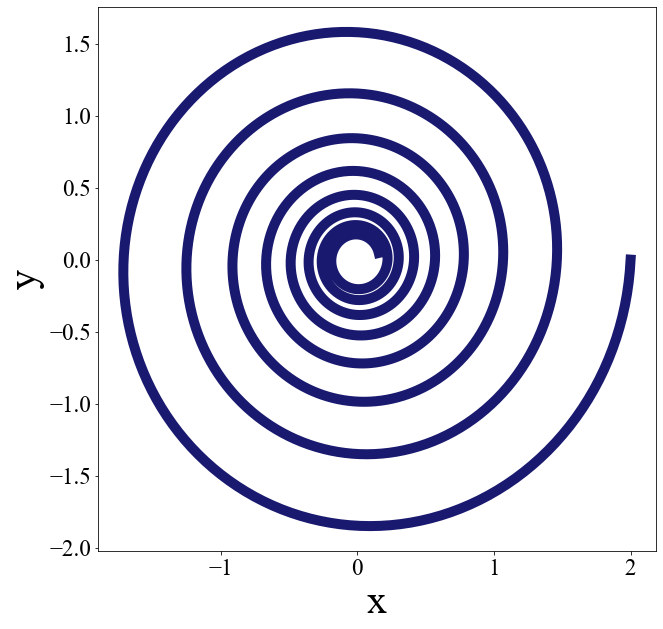

In [4]:
#size of pictures
figsize = 10,10
figure, ax = plt.subplots(figsize=figsize)
 
#Draw two lines on the same picture
plt.plot(x_train[:, 0], x_train[:, 1], 'midnightblue',linewidth=10.0)
 
#set the legend and the fontsize 
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 23,
}
plt.legend(loc='upper right',prop={'family':'Times New Roman','weight':'bold','size':23})
 
#Set the size of the coordinate scale value and the font
plt.tick_params(labelsize=23)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
 
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 40,
}
plt.xlabel('x',font2)
plt.ylabel('y',font2)
ax.legend_.remove()
plt.savefig("./Linear1.jpg",dpi=2000)  # save

In [5]:
import pysindy as ps
x_dot_precomputed = ps.FiniteDifference()._differentiate(x_train, t_train)#Ut

In [6]:
x_dot_precomputed.shape

(2500, 2)

In [7]:
# Candidate Functions 

def build_Theta(data, derivatives, derivatives_description, P, data_description = None):
    
    n,d = data.shape
    m, d2 = derivatives.shape
    if n != m: raise Exception('dimension error')
    if data_description is not None: 
        if len(data_description) != d: raise Exception('data descrption error')
    
    # Create a list of all polynomials in d variables up to degree P
    rhs_functions = {}
    f = lambda x, y : np.prod(np.power(list(x), list(y)))
    powers = []            
    for p in range(1,P+1):
            size = d + p - 1
            for indices in itertools.combinations(range(size), d-1):
                starts = [0] + [index+1 for index in indices]
                stops = indices + (size,)
                powers.append(tuple(map(operator.sub, stops, starts)))
    for power in powers: rhs_functions[power] = [lambda x, y = power: f(x,y), power]

    # First column of Theta is just ones.
    Theta = np.ones((n,1), dtype=np.complex64)
    descr = ['']
    
    # Add the derivaitves onto Theta
    for D in range(1,derivatives.shape[1]):
        Theta = np.hstack([Theta, derivatives[:,D].reshape(n,1)])
        descr.append(derivatives_description[D])
        
    # Add on derivatives times polynomials
    for D in range(derivatives.shape[1]):
        for k in rhs_functions.keys():
            func = rhs_functions[k][0]
            new_column = np.zeros((n,1), dtype=np.complex64)
            for i in range(n):
                new_column[i] = func(data[i,:])*derivatives[i,D]
            Theta = np.hstack([Theta, new_column])
            if data_description is None: descr.append(str(rhs_functions[k][1]) + derivatives_description[D])
            else:
                function_description = ''
                for j in range(d):
                    if rhs_functions[k][1][j] != 0:
                        if rhs_functions[k][1][j] == 1:
                            function_description = function_description + data_description[j]
                        else:
                            function_description = function_description + data_description[j] + '^' + str(rhs_functions[k][1][j])
                descr.append(function_description + derivatives_description[D])

    return Theta, descr

In [8]:
import itertools
import operator
# Form a huge matrix using up to quadratic polynomials in all variables.
X_data = x_train
X_ders = np.hstack([np.ones((2500,1))])
X_ders_descr = ['']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 5, data_description = ['x','y'])
['1'] + description[1:]

['1',
 'y',
 'x',
 'y^2',
 'xy',
 'x^2',
 'y^3',
 'xy^2',
 'x^2y',
 'x^3',
 'y^4',
 'xy^3',
 'x^2y^2',
 'x^3y',
 'x^4',
 'y^5',
 'xy^4',
 'x^2y^3',
 'x^3y^2',
 'x^4y',
 'x^5']

In [9]:
import scipy.io as sio
sio.savemat('2D_Linear.mat',{'Xt':x_dot_precomputed[:,0].reshape(2500,1),'Yt':x_dot_precomputed[:,1].reshape(2500,1),'R':X})